In [1]:

import sys
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import os
from glob import glob
import pandas as pd
from scipy.integrate import simps,cumtrapz

import matplotlib.pyplot as plt

import functools
#import warnings

import numpy as np
import george
from george.modeling import Model

from george import kernels

import emcee

import corner
import scipy.optimize as op

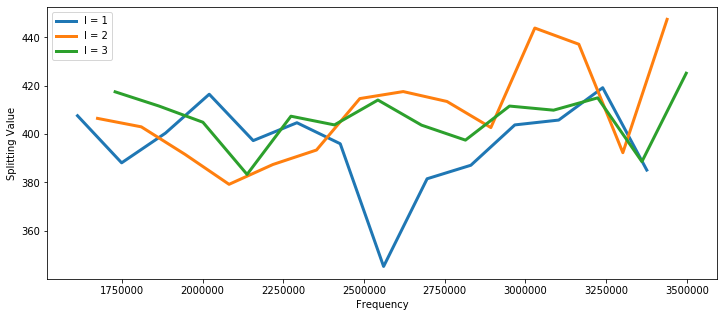

In [2]:
x_small = pd.read_table('x')
x_small = np.array(x_small)
flatx = x_small.flatten()


frequ = pd.read_table('freq.dat', sep='\s+')



# Load stuff once.
def load_kernels(dirname="kerns/", size=4800):
    paths = glob(dirname + "/l.*_n.*")
    max_l = 1 + max([int(path.split(".")[1].split("_")[0]) for path in paths])
    max_n = 1 + max([int(path.split(".")[-1]) for path in paths])

    kerns = np.nan * np.ones((max_l, max_n, size))

    for l in range(1 + max_l):
        for n in range(1 + max_n):
            path = os.path.join(dirname, "l.{l:.0f}_n.{n:.0f}".format(l=l, n=n))
            if not os.path.exists(path): continue
            kerns[l, n, :] = np.loadtxt(path, skiprows=1)

    return kerns

beta = np.loadtxt("beta.dat", skiprows=1) # l, n, beta
kerns = load_kernels()


freqnu = frequ.loc[frequ['n'] > 9]
freqnl = freqnu.loc[freqnu['n'] < 27]


freqs_1 = np.array(freqnl.loc[freqnl['l'] == 1]['Freqs'])*1E3
freqs_2 = np.array(freqnl.loc[freqnl['l'] == 2]['Freqs'])*1E3
freqs_3 = np.array(freqnl.loc[freqnl['l'] == 3]['Freqs'])*1E3


lone = np.ones((np.shape(freqs_1)[0],2))
ltwo = 2*np.ones((np.shape(freqs_2)[0],2))
lthree = 3*np.ones((np.shape(freqs_3)[0],2))

lone[:,0] = freqs_1
ltwo[:,0] = freqs_2
lthree[:,0] = freqs_3

xvals = np.append(lone,ltwo,axis = 0)
xvals = np.append(xvals,lthree,axis = 0)

freqs = np.array([freqs_1,freqs_2,freqs_3])

split_vals_1 = np.array(freqnl.loc[freqnl['l'] == 1]['delta'])
split_vals_2 = np.array(freqnl.loc[freqnl['l'] == 2]['delta'])
split_vals_3 = np.array(freqnl.loc[freqnl['l'] == 3]['delta'])


split_vals_plot = np.array([split_vals_1,split_vals_2,split_vals_3])

split_vals = np.append(split_vals_1,split_vals_2)
split_vals = np.append(split_vals, split_vals_3)



e_split_vals_1 = np.array(freqnl.loc[freqnl['l'] == 1]['e_delta'])
e_split_vals_2 = np.array(freqnl.loc[freqnl['l'] == 2]['e_delta'])
e_split_vals_3 = np.array(freqnl.loc[freqnl['l'] == 3]['e_delta'])

e_split_vals = np.append(e_split_vals_1,e_split_vals_2)
e_split_vals = np.append(e_split_vals, e_split_vals_3)


fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(freqs_1, split_vals_1, lw=3, label="l = 1");
ax.plot(freqs_2, split_vals_2, lw=3, label="l = 2");
ax.plot(freqs_3, split_vals_3, lw=3, label="l = 3");

ax.set_xlabel("Frequency"); ax.set_ylabel("Splitting Value"); plt.legend();
plt.show()

In [3]:
modelS = pd.read_table('modelS.dat', sep='\\s+')
# acoustic depth: tau(r) = int_r^R 1/c(x) dx (Aerts et al. eqn. 3.228)
cs = np.sqrt(modelS['c2'].values)
r  = modelS['r'].values
tau = np.hstack((0, -cumtrapz(1./cs, r)))

x_diffs = np.zeros_like(flatx)
for j in range(1,len(flatx)):
    x_diffs[j] = flatx[j] - flatx[j-1]

In [4]:
def splittings(omega, l):
    vals = []
    for n in freqnl.loc[freqnl['l']==l]['n']: # 0 to 35?
        area = np.dot(
            x_diffs,
            omega * kerns[l, n, :]
        )
        beta_mask = (beta[:, 0] == l) * (beta[:, 1] == n)
        delta = beta[beta_mask, 2] * area
    
        vals.append(delta[0])
    vals = np.array(vals)
#    if (l == 1):
#        vals = vals
#    else if (l == 2):
#        vals = 1.5*vals
#    else:
#        vals = 2*vals
    return vals

class Model(Model):
    parameter_names = ("a", "b","c","d")

    def get_value(self, t):
        rot_prof = self.a * np.arctan(flatx*self.b-self.c)+self.d
        vals = np.append(splittings(rot_prof,1),splittings(rot_prof,2))
        vals = np.append(vals,splittings(rot_prof,3))
        return vals

    def get_value_plot(self, t):
        rot_prof = self.a * np.arctan(flatx*self.b-self.c)+self.d
        vals = np.array([splittings(rot_prof,1),splittings(rot_prof,2),splittings(rot_prof,3)])
        return vals

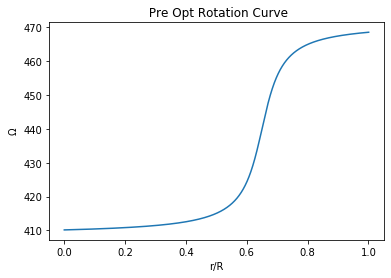

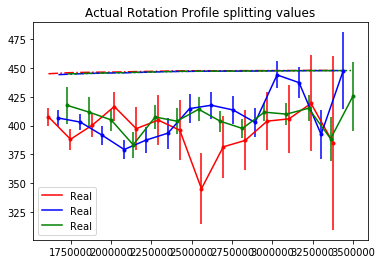

In [5]:
truth = dict(a=-20, b=-20, c=-13,  d= 440)#log_sigma=np.log(0.4))

kwargs = dict(**truth)
kwargs["bounds"] = dict(a=(-100,50),b = (-50,-15),c = (-50,-10),d = (200,500))
#kwargs["bounds"] = dict(a=(-5,5), b = (0,15),c = (0,10.))
mean_model = Model(**kwargs)

plt.figure()
ao,bo,co,do = mean_model.get_parameter_vector()
actual_rot = ao * np.arctan(flatx*bo-co)+do
plt.plot(flatx,actual_rot)
plt.title(' Pre Opt Rotation Curve')
plt.xlabel('r/R')
plt.ylabel(r'$\Omega$')
#plt.ylim(0,500)
plt.show()

plt.figure()

actual_1 = splittings(actual_rot,1)
actual_2 = splittings(actual_rot,2)
actual_3 = splittings(actual_rot,3)


plt.plot(freqs_1,actual_1, linestyle = '-.', color = 'red')
plt.plot(freqs_2,actual_2, linestyle = '-.', color = 'blue')
plt.plot(freqs_3,actual_3, linestyle = '-.', color = 'green')

plt.plot(freqs[0],split_vals_plot[0],label = 'Real', color = 'red')
plt.errorbar(freqs[0],split_vals_plot[0],yerr = e_split_vals_1, fmt=".r", capsize=0)
#plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'First Guess', color = 'red', linestyle = '-.')
plt.plot(freqs[1],split_vals_plot[1],label = 'Real', color = 'blue')
plt.errorbar(freqs[1],split_vals_plot[1],yerr = e_split_vals_2, fmt=".b", capsize=0)
#plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'First Guess',color = 'red', linestyle = '-.')
plt.plot(freqs[2],split_vals_plot[2],label = 'Real', color = 'green')
plt.errorbar(freqs[2],split_vals_plot[2],yerr = e_split_vals_3, fmt=".g", capsize=0)
#plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'First Guess', color = 'green', linestyle = '-.')
plt.legend(loc = 'best')
plt.title('Actual Rotation Profile splitting values')

plt.show()

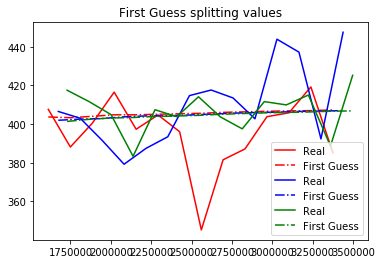

In [9]:
gp = george.GP(1 * kernels.ExpSquaredKernel(metric=1e-3 * np.eye(2), ndim=2, metric_bounds=[(-10, 15), (None, None), (-10, 10)]), mean = mean_model, fit_mean=True, fit_white_noise=True)

#gp = george.GP(1 * kernels.ExpSquaredKernel(metric=1e-5 * np.eye(2), ndim=2, metric_bounds=[(-10, 10), (None, None), (-6, -2.3)]))


gp.set_parameter('kernel:k2:metric:L_0_1',0)
gp.freeze_parameter('kernel:k2:metric:L_0_1')

#this is the part where im confused
#gp.compute(flatx)



gp.compute(xvals, e_split_vals)

def log_prior(p):
#    a, b, c,d,k1_log_constant, k2_M_0, k2_M_1 = p
#    #k1_log_constant, k2_M_0, k2_M_1 = p
#
##    if not (15 >= b >= 0):
##        return -np.inf
#    if not all(i > 0 for i in (a * np.arctan(flatx*b-c)+d)):
#        return -np.inf
    return 0


def log_prob(p):
    gp.set_parameter_vector(p)
    return log_prior(p) \
        +   gp.log_prior() + gp.log_likelihood(split_vals, quiet=True)

def negative_log_prob(p):
    return -log_prob(p)
    

def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(split_vals, quiet=True)

#take a plot of initial guess
plt.figure()

plt.plot(freqs[0],split_vals_plot[0],label = 'Real', color = 'red')
plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'First Guess', color = 'red', linestyle = '-.')
plt.plot(freqs[1],split_vals_plot[1],label = 'Real', color = 'blue')
plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'First Guess',color = 'blue', linestyle = '-.')
plt.plot(freqs[2],split_vals_plot[2],label = 'Real', color = 'green')
plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'First Guess', color = 'green', linestyle = '-.')
plt.legend(loc = 'best')
plt.title('First Guess splitting values')
plt.show()

31.072553676755994 -31.968949574455323 -19.279110066204204 426.9749605453556
-176.8536136972553
-176.09112727464668
-175.9079028534669
-175.85738090907253
-175.85694885937514
49.999999999870646 -39.43671575560813 -23.91498457338742 438.9011834661789


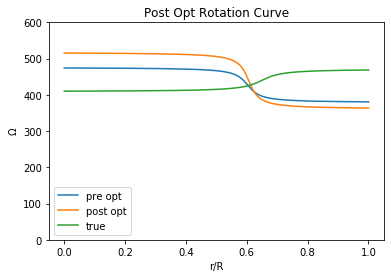

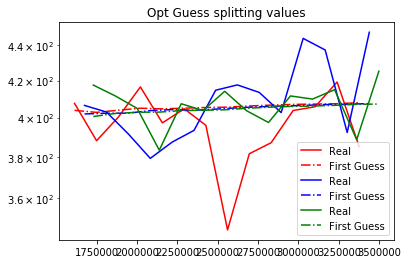

In [10]:

plt.figure()

ao,bo,co,do = mean_model.get_parameter_vector()
print(ao,bo,co,do)
plt.plot(flatx,ao * np.arctan(flatx*bo-co)+do, label = 'pre opt')

print(gp.log_likelihood(split_vals))

gp.freeze_all_parameters()
gp.thaw_parameter('white_noise:value')
p0 = gp.get_parameter_vector()
results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
print(gp.log_likelihood(split_vals))

gp.set_parameter_vector(results.x)


gp.thaw_all_parameters()
gp.freeze_parameter('kernel:k2:metric:L_0_1')
gp.freeze_parameter('mean:b')
gp.freeze_parameter('mean:c')
p0 = gp.get_parameter_vector()
results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
print(gp.log_likelihood(split_vals))
gp.set_parameter_vector(results.x)

gp.thaw_all_parameters()
gp.freeze_parameter('kernel:k2:metric:L_0_1')
# gp.freeze_parameter('mean:d')

# p0 = gp.get_parameter_vector()
# results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
# gp.set_parameter_vector(results.x)

# gp.set_parameter_vector(results.x)

# gp.thaw_all_parameters()
# gp.freeze_parameter('kernel:k2:metric:L_0_1')
# gp.freeze_parameter('mean:a')

# p0 = gp.get_parameter_vector()
# results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
# gp.set_parameter_vector(results.x)

gp.freeze_parameter('mean:a')
gp.freeze_parameter('mean:d')
p0 = gp.get_parameter_vector()
results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
print(gp.log_likelihood(split_vals))

gp.set_parameter_vector(results.x)

gp.thaw_all_parameters()
gp.freeze_parameter('kernel:k2:metric:L_0_1')


p0 = gp.get_parameter_vector()
results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
gp.set_parameter_vector(results.x)
mean_model.set_parameter_vector(results.x[0:4])


print(gp.log_likelihood(split_vals))



ao,bo,co,do = mean_model.get_parameter_vector()
print(ao,bo,co,do)
plt.plot(flatx,ao * np.arctan(flatx*bo-co)+do, label = 'post opt')
plt.plot(flatx,actual_rot,label = 'true')
plt.title('Post Opt Rotation Curve')
plt.xlabel('r/R')
plt.ylabel(r'$\Omega$')
plt.ylim(0,600)
plt.legend(loc = 'best')
plt.show()

#take a plot of initial guess
plt.figure()

plt.plot(freqs[0],split_vals_1,label = 'Real', color = 'red')
plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'First Guess', color = 'red', linestyle = '-.')
plt.plot(freqs[1],split_vals_2,label = 'Real', color = 'blue')
plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'First Guess',color = 'blue', linestyle = '-.')
plt.plot(freqs[2],split_vals_3,label = 'Real', color = 'green')
plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'First Guess', color = 'green', linestyle = '-.')
plt.legend(loc = 'best')
#plt.ylim(400,500)
plt.yscale('log')
plt.title('Opt Guess splitting values')
plt.show()

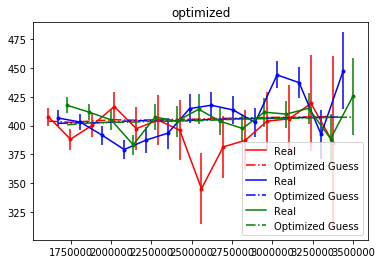

In [11]:
plt.figure()
plt.plot(freqs[0],split_vals_plot[0],label = 'Real', color = 'red')
plt.errorbar(freqs[0],split_vals_plot[0],yerr = e_split_vals_1, fmt=".r", capsize=0)
plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'Optimized Guess', color ='red', linestyle = '-.')

plt.plot(freqs[1],split_vals_plot[1],label = 'Real', color = 'blue')
plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'Optimized Guess', color ='blue', linestyle = '-.')
plt.errorbar(freqs[1],split_vals_plot[1],yerr = e_split_vals_2, fmt=".b", capsize=0)

plt.plot(freqs[2],split_vals_plot[2],label = 'Real', color = 'green')
plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'Optimized Guess', color ='green', linestyle = '-.')
plt.errorbar(freqs[2],split_vals_plot[2],yerr = e_split_vals_2, fmt=".g", capsize=0)
plt.title('optimized')
plt.legend(loc = 'best')
plt.show()




In [12]:
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 50
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

print("Running first burn-in...")
p0 = initial + 1e-5 * np.random.randn(nwalkers, ndim)
state = sampler.run_mcmc(p0, 5000)

Running first burn-in...


[  -26.2108185    -46.12922325   -33.14804168   396.41377148
  -631.95427916 -1540.98791628    -4.07339855     5.06138134]
[400.96868154 402.45062751 402.34405822 402.62784508 403.02056252
 403.18217325 403.74058159 403.71257185 403.51578516 403.64321597
 403.56335405 403.64954587 403.71323599 403.56184377 400.34719197
 401.41256466 401.95602098 401.84681093 402.61893657 403.07127324
 403.20176101 403.41864095 403.22734582 403.29941842 403.49206747
 403.42879803 403.5237599  403.48698717 401.40491386 401.51911206
 402.11619697 402.34905932 402.70322833 403.38933824 403.34559981
 403.30770762 403.41407675 403.3432921  403.5257578  403.5663637
 403.46811577 403.54127532]


ValueError: x and y must have same first dimension, but have shapes (14,) and (17,)

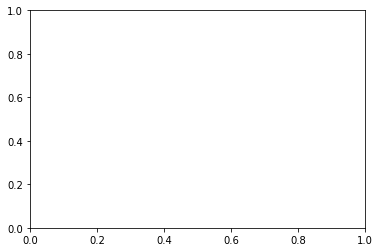

In [13]:
# Plot the data
#plt.errorbar(freqs_1, split_vals_1, yerr=e_split_vals_1, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
# ARC says: not sure what this was meant for...

x = np.linspace(1000, 3000, 5000)


# Plot 24 posterior samples.
plt.figure()
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=200)]:
    print(s)
    gp.set_parameter_vector(s)
    m = gp.sample_conditional(split_vals, xvals)
    print(m)
    plt.plot(freqs[0], m[0:17], color="red", alpha=0.1)
    plt.plot(freqs[1], m[17:34], color="blue", alpha=0.1)
    plt.plot(freqs[2], m[34:51], color="green", alpha=0.1)


plt.plot(freqs[0],split_vals_plot[0],label = 'Real', color = 'red')
plt.errorbar(freqs[0],split_vals_plot[0],yerr = e_split_vals_1, fmt=".r", capsize=0)
plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'Optimized Guess', color ='red', linestyle = '-.')

plt.plot(freqs[1],split_vals_plot[1],label = 'Real', color = 'blue')
plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'Optimized Guess', color ='blue', linestyle = '-.')
plt.errorbar(freqs[1],split_vals_plot[1],yerr = e_split_vals_2, fmt=".b", capsize=0)

plt.plot(freqs[2],split_vals_plot[2],label = 'Real', color = 'green')
plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'Optimized Guess', color ='green', linestyle = '-.')
plt.errorbar(freqs[2],split_vals_plot[2],yerr = e_split_vals_2, fmt=".g", capsize=0)


plt.ylabel("Splitting")
plt.xlabel("Frequency")
#plt.xlim(-5, 5)
plt.title("Sampled with GP noise model");
#
plt.show()

names = gp.get_parameter_names()
inds = np.array([names.index(k) for k in names])
corner.corner(sampler.chain[:, 2500:, :].reshape((-1, 8)), labels=names)

#names = gp.get_parameter_names()
#corner.corner(sampler.chain.reshape((-1, 3)), labels=names)

plt.figure()
fig, axs = plt.subplots(7)
fig.suptitle('Sampler Chains')
for i in range(50): axs[0].plot(sampler.chain[i,:,0],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[1].plot(sampler.chain[i,:,1],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[2].plot(sampler.chain[i,:,2],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[3].plot(sampler.chain[i,:,3],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[4].plot(sampler.chain[i,:,4],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[5].plot(sampler.chain[i,:,5],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[6].plot(sampler.chain[i,:,6],color = 'tab:blue', alpha = 0.01)

axs[0].set_ylabel('a')
axs[1].set_ylabel('b')
axs[2].set_ylabel('c')
axs[3].set_ylabel('d')
axs[4].set_ylabel('Log_constant')
axs[5].set_ylabel('log_L_0_0')
axs[6].set_ylabel('log_L_1_1')